# Compare Temperature Across Locations
* TMAX: The maximum temperature on a day
* TMIN: The minimum temperature on a day
* TAVG: (If available) The average temperature on a day

In [26]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
sys.path.append(os.path.dirname(os.getcwd()))

import functions
# from functions import map_stations

In [6]:
# Station 1 - Clatskanie
df = pd.read_csv('../data/temperature_97016.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df[df['year']<2025]

# Verify station 
# functions.view_station_date_ranges(df)
# geo_data = pd.read_csv('../data/geo_data.csv')
# functions.map_stations(geo_data)

df1 = df[df['STATION']=='USC00351643']
# df[df['TAVG'].notnull()]['STATION'].unique()

In [7]:
# Station 2 - Portland
df = pd.read_csv('../data/temperature_97218.csv')
df = df.assign(year = pd.to_datetime(df['DATE']).dt.year)
df = df[df['year']<2025]
df.STATION.unique()

df2 = df.copy()

In [8]:
# Merge the stations into one df
df1_suffix = '_CLATSKANIE'
df2_suffix = '_PDX'
df = df1.merge(df2,
          on=['DATE', 'year'],
          how='inner',
          suffixes=(df1_suffix, df2_suffix)
          ).drop(['STATION_PDX', 'STATION_CLATSKANIE'], axis=1)

In [9]:
df.describe()

,TAVG_CLATSKANIE,TMAX_CLATSKANIE,TMIN_CLATSKANIE,year,TAVG_PDX,TMAX_PDX,TMIN_PDX
count,0.0,30638.000000,30636.000000,30728.000000,6971.000000,30728.000000,30728.000000
mean,NaN,59.716888,42.249478,1982.389319,55.447138,62.787002,45.150807
std,NaN,12.642279,9.147526,24.323240,11.733747,14.488503,9.873956
min,NaN,17.000000,1.000000,1940.000000,18.000000,14.000000,-3.000000
25%,NaN,50.000000,35.000000,1961.000000,46.000000,52.000000,38.000000
50%,NaN,59.000000,42.000000,1982.000000,55.000000,61.000000,45.000000
75%,NaN,69.000000,50.000000,2003.000000,65.000000,73.000000,53.000000
max,NaN,103.000000,66.000000,2024.000000,96.000000,116.000000,75.000000


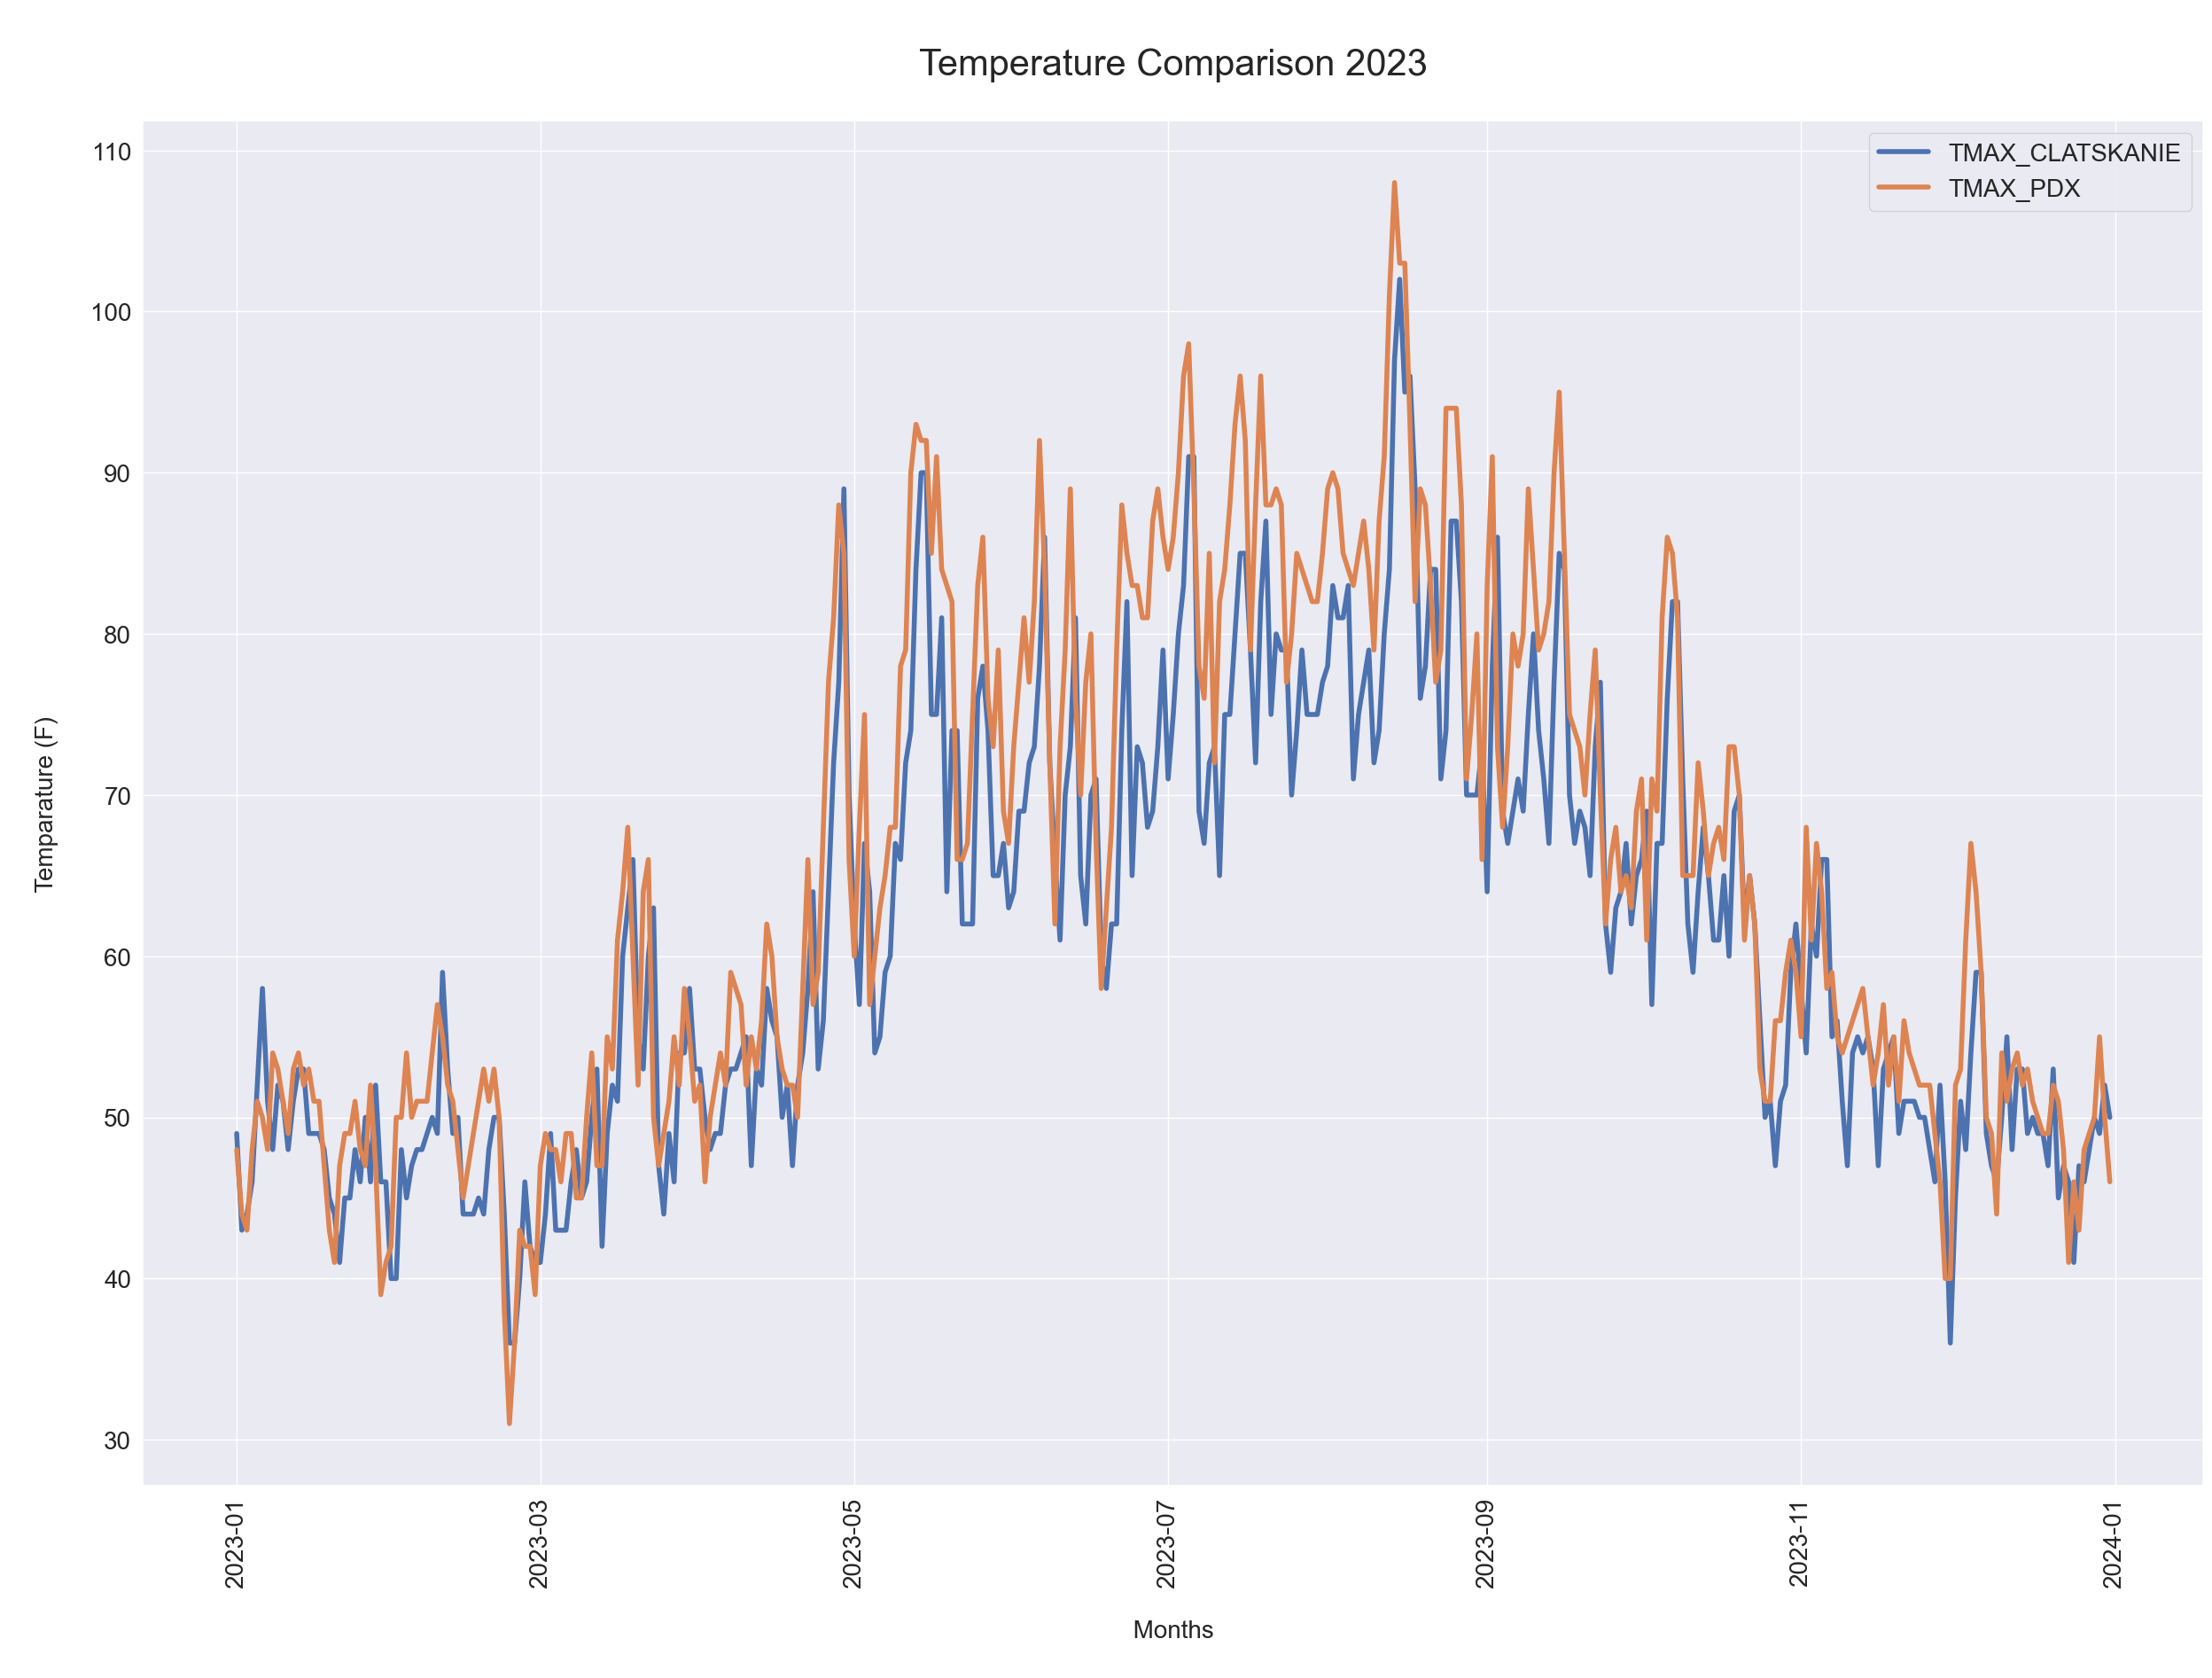

In [10]:
# Plot maximum temperature
pmax = functions.plot_temp_compare(df, 'TMAX', 2023)
# pmax.savefig('tmax_compare.jpg') 

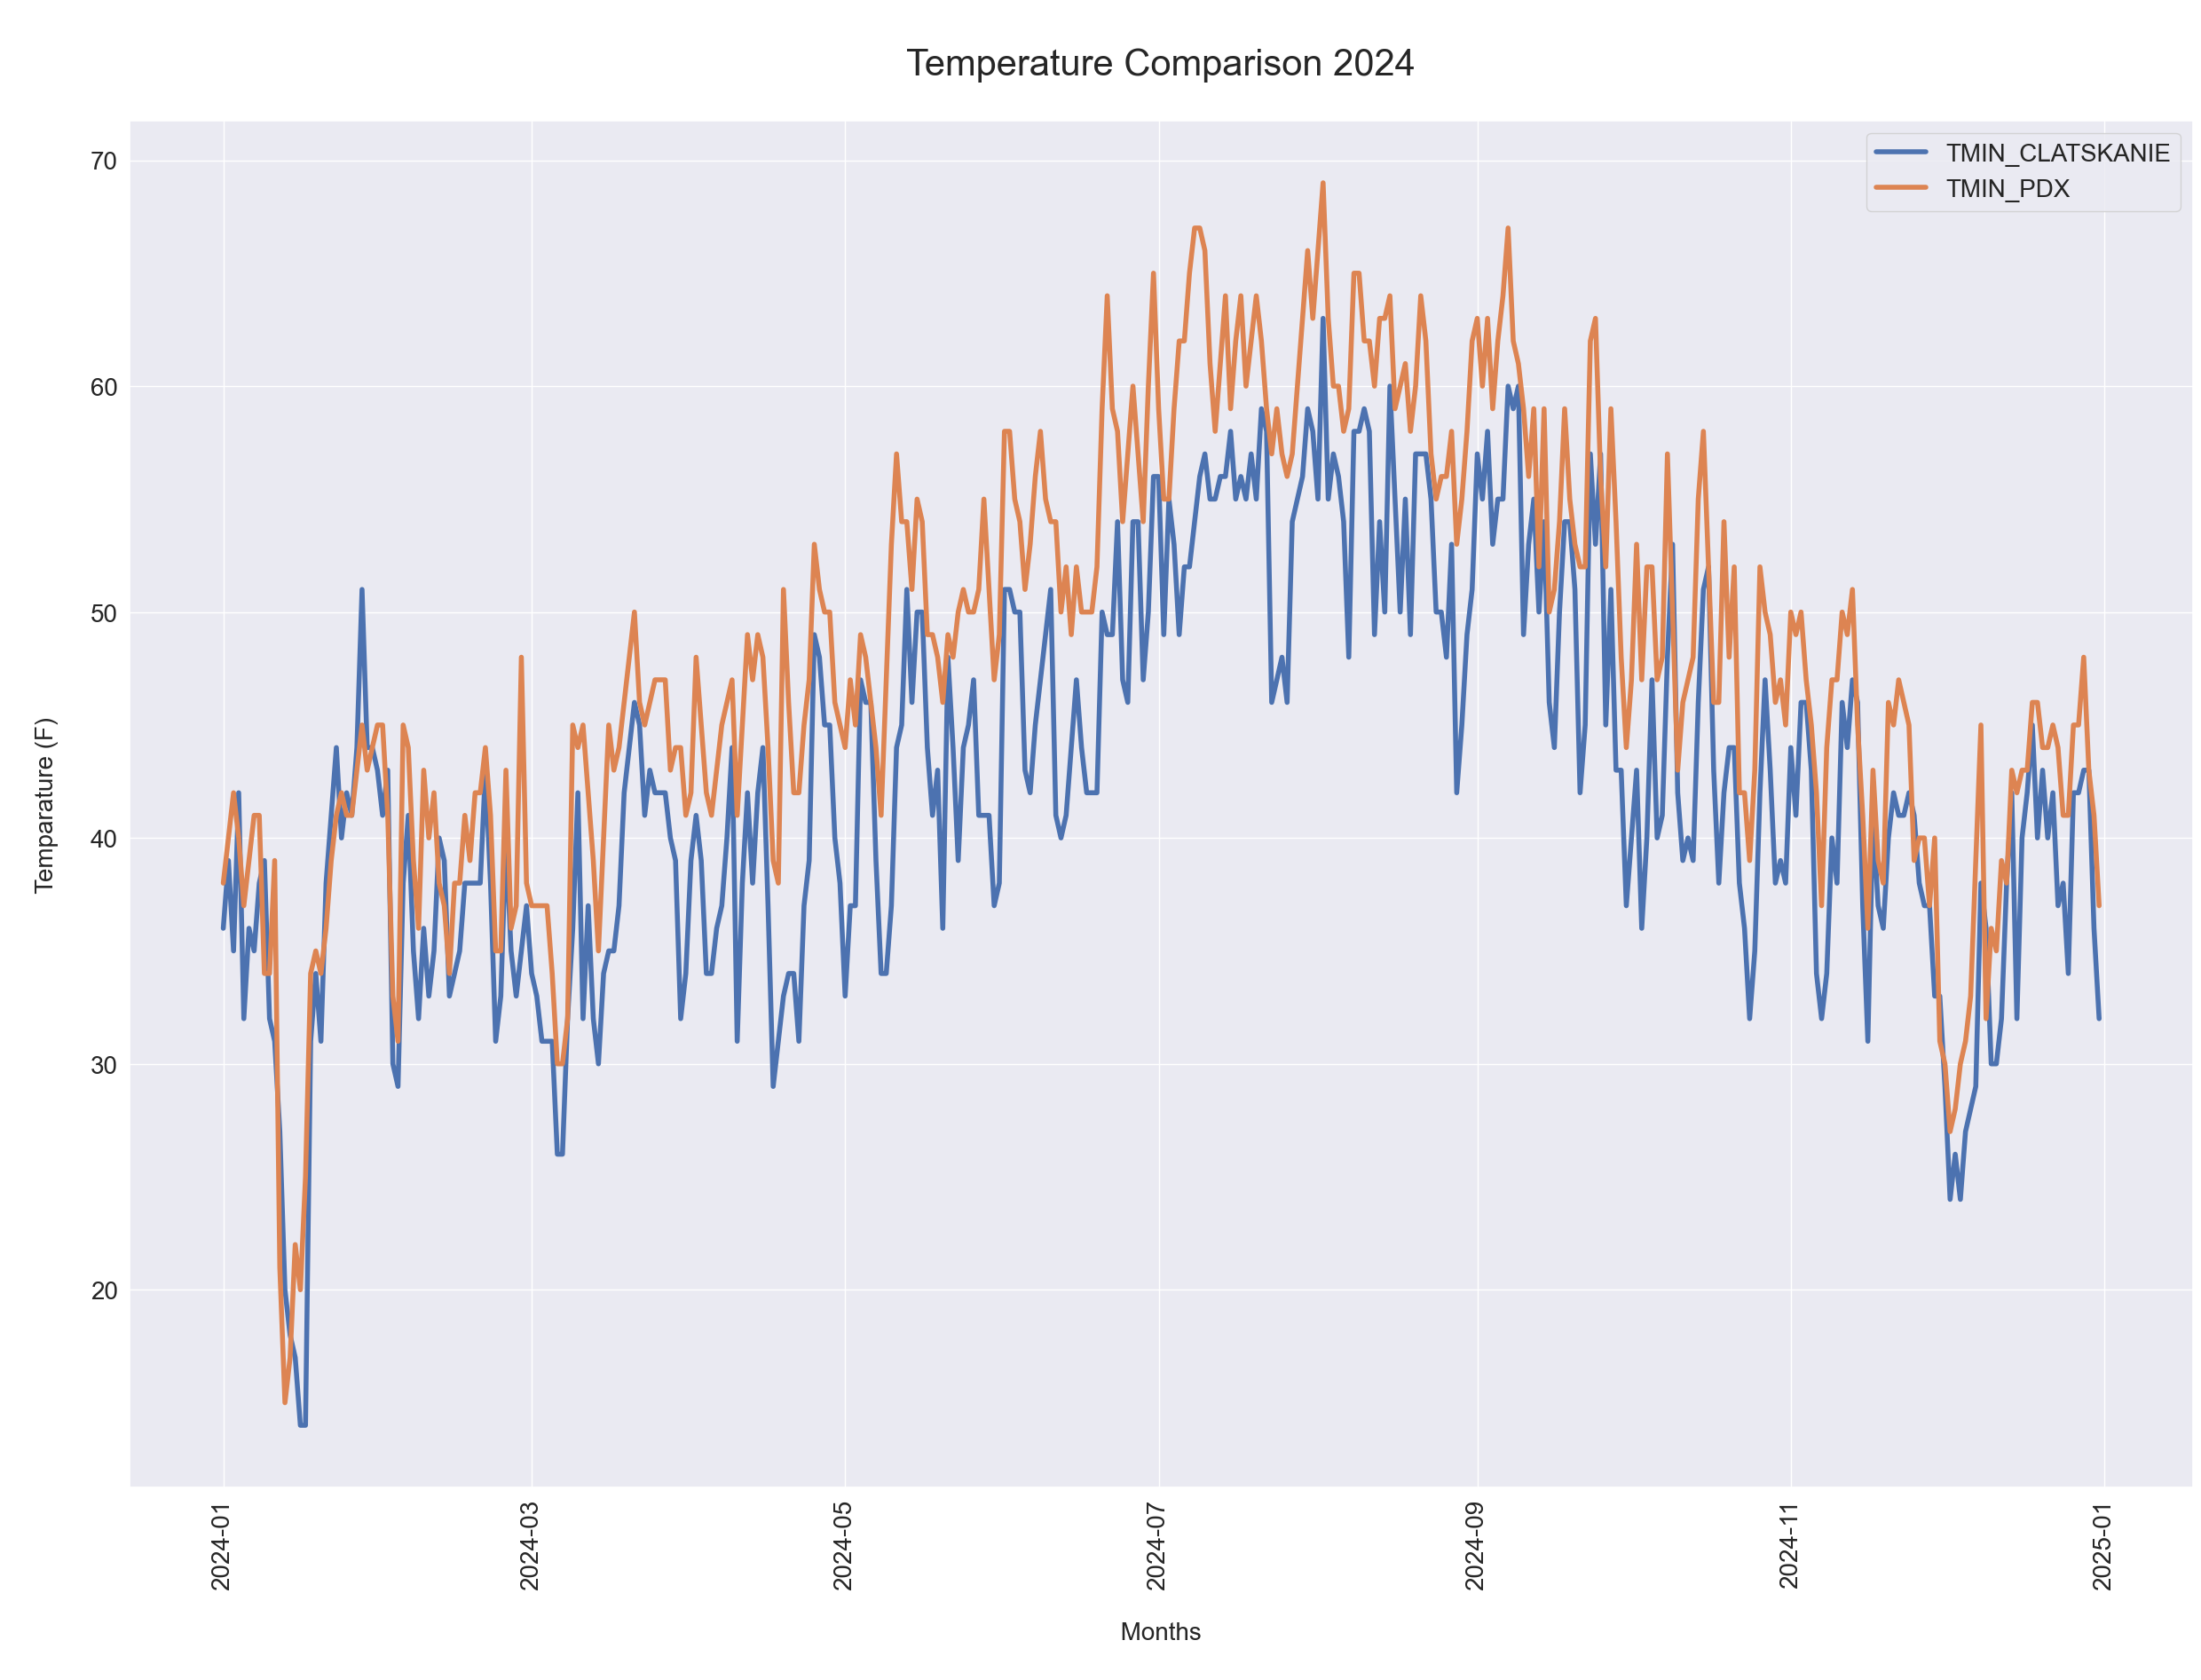

In [11]:
# Plot minimum temperature
pmin = functions.plot_temp_compare(df, 'TMIN', 2024)
# pmin.savefig('tmin_compare.jpg') 

In [28]:
# Compare USDA Hardiness zone (i.e. the minimum temperature for each of the last 30 years, averaged)
print("USDA Zone 8a: 10 to 25 Fahrenheit")
print("USDA Zone 8b: 15 to 20 Fahrenheit")
print("USDA Zone 9a: 20 to 25 Fahrenheit")
print("USDA Zone 9b: 25 to 30 Fahrenheit")
# Station 1 - Clatskanie
s1 = pd.read_csv('../data/temperature_97016.csv')
s1 = s1.assign(year = pd.to_datetime(s1['DATE']).dt.year)
s1 = s1.groupby('year', as_index=False).agg({'TMIN': 'min'}).tail(30)
print("The hardiness zone for station 1 is", np.mean(s1['TMIN']))

# Station 2 - Portland
s2 = pd.read_csv('../data/temperature_97218.csv')
s2 = s2.assign(year = pd.to_datetime(s2['DATE']).dt.year)
s2 = s2.groupby('year', as_index=False).agg({'TMIN': 'min'}).tail(30)
print("The hardiness zone for station 2 is", np.mean(s2['TMIN']))

USDA Zone 8a: 10 to 25 Fahrenheit
USDA Zone 8b: 15 to 20 Fahrenheit
USDA Zone 9a: 20 to 25 Fahrenheit
USDA Zone 9b: 25 to 30 Fahrenheit
The hardiness zone for station 1 is 13.166666666666666
The hardiness zone for station 2 is 20.433333333333334


In [34]:
# However, it looks like there's a bad data point in s1, -76 in 2001 seems incorrect
s1.sort_values('TMIN')
# s2.sort_values('TMIN')

,year,TMIN
69,2001,-76.0
77,2009,7.0
66,1998,9.0
81,2013,10.0
85,2017,12.0
78,2010,13.0
76,2008,13.0
64,1996,13.0
92,2024,14.0
79,2011,14.0


In [41]:
s1 = s1.sort_values('TMIN').tail(29)

In [43]:
# Compare USDA Hardiness zone (i.e. the minimum temperature for each of the last 30 years, averaged)
print("USDA Zone 8a: 10 to 25 Fahrenheit")
print("USDA Zone 8b: 15 to 20 Fahrenheit")
print("USDA Zone 9a: 20 to 25 Fahrenheit")
print("USDA Zone 9b: 25 to 30 Fahrenheit")
print("The hardiness zone for station 1 is", np.mean(s1['TMIN']))
print("The hardiness zone for station 2 is", np.mean(s2['TMIN']))

USDA Zone 8a: 10 to 25 Fahrenheit
USDA Zone 8b: 15 to 20 Fahrenheit
USDA Zone 9a: 20 to 25 Fahrenheit
USDA Zone 9b: 25 to 30 Fahrenheit
The hardiness zone for station 1 is 16.24137931034483
The hardiness zone for station 2 is 20.433333333333334
